In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
from isaac.dataset import read_dataset, prepare_dataset, sample_subsequences, split_in_subsequences, add_mouse_columns_to_passive_trials
from isaac.utils import plot_confusion_matrix
from isaac.models import RNNModel, ComplexRNNModel, initialise_model
from isaac.constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS, YOKED_TRAINING_COLS, MOUSE_COLS
from isaac.training import evaluate, training_loop, evaluate_saved_model
from isaac.sanity import class_proportions

In [4]:
BATCH_SIZE = 128
EPOCHS = 200
NORMALISE_DATA = True
STEP_SIZE = 2
SEQ_END = 1800

# Define common model, loss and optimizer

In [5]:
INPUT_DIM = len(BASIC_TRAINING_COLS)    # input dimension
HIDDEN_DIM = 25  # hidden layer dimension
N_LAYERS = 4     # number of hidden layers
OUTPUT_DIM = 3   # output dimension
DROPOUT = 0.5

network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)

In [6]:
exp1_trials = read_dataset("data/yoked_trials_exp1.h5")
exp2_mass_trials = read_dataset("data/mass_trials_exp2.h5")
exp2_force_trials = read_dataset("data/force_trials_exp2.h5")

first_half = [trial[:1801] for trial in exp1_trials]
second_half = [trial[-1801:] for trial in exp1_trials]

100%|██████████| 399/399 [00:06<00:00, 58.97it/s]


In [34]:
yoked_trials = first_half + second_half

for trial in tqdm(yoked_trials):
    trial.mouseX = trial.mouseX * (trial.idControlledObject != "none").astype(int)
    trial.mouseY = trial.mouseY * (trial.idControlledObject != "none").astype(int)

In [48]:
np.random.seed(0)
indices = np.arange(len(yoked_trials))
test_indices = np.random.choice(indices, 1, replace=False)
val_indices = np.random.choice(list(set(indices) - set(test_indices)), 100, replace=False)
train_indices = list(set(indices) - set(test_indices) - set(val_indices))

train_trials = [yoked_trials[i] for i in train_indices]
val_trials = [yoked_trials[i] for i in val_indices]
test_trials = [yoked_trials[i] for i in test_indices]

train_trials = exp2_force_trials + exp2_mass_trials
val_trials = first_half
test_trials = second_half

In [49]:
len(train_trials), len(val_trials), len(test_trials)

(185, 100, 1)

# FORCE TRAINING  (Humans achieve 63% +- 21%)

## Read dataset and preprocess it

In [50]:
scaler_path = "scalers/passive_force_scaler.sk"
scaler = joblib.load(scaler_path)

In [51]:
loaders, scaler = prepare_dataset([train_trials, val_trials, test_trials], class_columns=FORCE_CLASS_COLS, 
                                  training_columns=BASIC_TRAINING_COLS,
                                  batch_size=BATCH_SIZE, normalise_data=NORMALISE_DATA)


100%|██████████| 1/1 [00:00<00:00, 387.43it/s]

In [52]:
train_loader, val_loader, test_loader = loaders

In [53]:
class_proportions(train_loader)
print()
class_proportions(val_loader)
print()
class_proportions(test_loader)

[47 85 53]
Majority class:  0.4594594594594595

[31 45 24]
Majority class:  0.45

[1]
Majority class:  1.0


## Define model, loss and optimizer

In [56]:
model_path = "models/passive_force_model.pt"
model = ComplexRNNModel(*network_dims, DROPOUT)
model.load_state_dict(torch.load(model_path))
model = model.cuda()
model.rec_one.requires_grad = False

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model.train()

ComplexRNNModel(
  (rec_one): GRU(16, 25, num_layers=2, batch_first=True, dropout=0.5)
  (rec_two): GRU(25, 25, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=25, out_features=3, bias=True)
)

model_path = "models/passive_force_model.pt"
pretrained_model = ComplexRNNModel(*network_dims, DROPOUT)
pretrained_model.load_state_dict(torch.load(model_path))

class DualRNNModel(nn.Module):
    def __init__(self, dropout=0.):
        super(DualRNNModel, self).__init__()
        # RNN
        self.lstm = pretrained_model.lstm
        self.gru = nn.GRU(25 + 7, 20, 2, batch_first=True, dropout=dropout)
        # Readout layer
        self.fc = nn.Linear(20, 3)
    
    def forward(self, x):
        obj = x[:, : , :-7]
        mouse = x[:, :, -7:]
        
        out, _ = self.lstm(obj)
        
        out = torch.cat((out, mouse), dim=2)
        out, _ = self.gru(out)
        
        out = self.fc(out[:, -1, :]) 
        return out

dual = DualRNNModel(DROPOUT)
error = nn.CrossEntropyLoss().cuda()

dual.lstm.requires_grad = True
optimizer = torch.optim.Adam(dual.parameters(), lr=0.0001)

dual.train()
dual = dual.cuda()

## Train model and plot loss and accuracy

In [57]:
epoch_losses, epoch_accuracies, best_model = training_loop(model, optimizer, error, train_loader, val_loader, 
                                                           EPOCHS, seq_end=SEQ_END, step_size=STEP_SIZE)



  0%|          | 0/200 [00:00<?, ?it/s]

Train_loss (2.93)	 Train_acc (47.03)	 Val_acc (48.00):   0%|          | 0/200 [00:00<?, ?it/s]

Train_loss (2.93)	 Train_acc (47.03)	 Val_acc (48.00):   0%|          | 1/200 [00:00<02:24,  1.38it/s]

Train_loss (2.87)	 Train_acc (48.11)	 Val_acc (49.00):   0%|          | 1/200 [00:01<02:24,  1.38it/s]

Train_loss (2.87)	 Train_acc (48.11)	 Val_acc (49.00):   1%|          | 2/200 [00:01<02:21,  1.40it/s]

Train_loss (2.77)	 Train_acc (49.19)	 Val_acc (50.00):   1%|          | 2/200 [00:02<02:21,  1.40it/s]

Train_loss (2.77)	 Train_acc (49.19)	 Val_acc (50.00):   2%|▏         | 3/200 [00:02<02:18,  1.42it/s]

Train_loss (2.72)	 Train_acc (49.19)	 Val_acc (50.00):   2%|▏         | 3/200 [00:02<02:18,  1.42it/s]

Train_loss (2.72)	 Train_acc (49.19)	 Val_acc (50.00):   2%|▏         | 4/200 [00:02<02:14,  1.46it/s]

Train_loss (2.60)	 Train_acc (49.73)	 Val_acc (50.00):   2%|▏         | 4/200 [00:03<02:14,  1.46it/s]

Train_loss (2.60)	 Train_acc 

Train_loss (1.11)	 Train_acc (60.54)	 Val_acc (53.00):  18%|█▊        | 37/200 [00:25<01:51,  1.47it/s]

Train_loss (1.06)	 Train_acc (60.00)	 Val_acc (52.00):  18%|█▊        | 37/200 [00:26<01:51,  1.47it/s]

Train_loss (1.06)	 Train_acc (60.00)	 Val_acc (52.00):  19%|█▉        | 38/200 [00:26<01:49,  1.48it/s]

Train_loss (1.02)	 Train_acc (60.00)	 Val_acc (51.00):  19%|█▉        | 38/200 [00:26<01:49,  1.48it/s]

Train_loss (1.02)	 Train_acc (60.00)	 Val_acc (51.00):  20%|█▉        | 39/200 [00:26<01:47,  1.50it/s]

Train_loss (1.07)	 Train_acc (60.00)	 Val_acc (51.00):  20%|█▉        | 39/200 [00:27<01:47,  1.50it/s]

Train_loss (1.07)	 Train_acc (60.00)	 Val_acc (51.00):  20%|██        | 40/200 [00:27<01:45,  1.52it/s]

Train_loss (1.09)	 Train_acc (60.00)	 Val_acc (50.00):  20%|██        | 40/200 [00:27<01:45,  1.52it/s]

Train_loss (1.09)	 Train_acc (60.00)	 Val_acc (50.00):  20%|██        | 41/200 [00:27<01:44,  1.53it/s]

Train_loss (1.01)	 Train_acc (60.00)	 Val_acc (49.00): 

Train_loss (0.68)	 Train_acc (68.65)	 Val_acc (49.00):  36%|███▋      | 73/200 [00:50<01:25,  1.49it/s]

Train_loss (0.68)	 Train_acc (68.65)	 Val_acc (49.00):  37%|███▋      | 74/200 [00:50<01:24,  1.48it/s]

Train_loss (0.69)	 Train_acc (68.11)	 Val_acc (49.00):  37%|███▋      | 74/200 [00:51<01:24,  1.48it/s]

Train_loss (0.69)	 Train_acc (68.11)	 Val_acc (49.00):  38%|███▊      | 75/200 [00:51<01:23,  1.50it/s]

Train_loss (0.66)	 Train_acc (68.11)	 Val_acc (48.00):  38%|███▊      | 75/200 [00:51<01:23,  1.50it/s]

Train_loss (0.66)	 Train_acc (68.11)	 Val_acc (48.00):  38%|███▊      | 76/200 [00:51<01:21,  1.52it/s]

Train_loss (0.66)	 Train_acc (68.11)	 Val_acc (49.00):  38%|███▊      | 76/200 [00:52<01:21,  1.52it/s]

Train_loss (0.66)	 Train_acc (68.11)	 Val_acc (49.00):  38%|███▊      | 77/200 [00:52<01:20,  1.53it/s]

Train_loss (0.64)	 Train_acc (69.19)	 Val_acc (49.00):  38%|███▊      | 77/200 [00:53<01:20,  1.53it/s]

Train_loss (0.64)	 Train_acc (69.19)	 Val_acc (49.00): 

Train_loss (0.49)	 Train_acc (75.68)	 Val_acc (49.00):  55%|█████▌    | 110/200 [01:14<01:02,  1.45it/s]

Train_loss (0.44)	 Train_acc (76.22)	 Val_acc (49.00):  55%|█████▌    | 110/200 [01:15<01:02,  1.45it/s]

Train_loss (0.44)	 Train_acc (76.22)	 Val_acc (49.00):  56%|█████▌    | 111/200 [01:15<01:03,  1.41it/s]

Train_loss (0.45)	 Train_acc (76.22)	 Val_acc (49.00):  56%|█████▌    | 111/200 [01:16<01:03,  1.41it/s]

Train_loss (0.45)	 Train_acc (76.22)	 Val_acc (49.00):  56%|█████▌    | 112/200 [01:16<01:03,  1.39it/s]

Train_loss (0.44)	 Train_acc (75.68)	 Val_acc (49.00):  56%|█████▌    | 112/200 [01:16<01:03,  1.39it/s]

Train_loss (0.44)	 Train_acc (75.68)	 Val_acc (49.00):  56%|█████▋    | 113/200 [01:16<01:03,  1.38it/s]

Train_loss (0.43)	 Train_acc (75.68)	 Val_acc (49.00):  56%|█████▋    | 113/200 [01:17<01:03,  1.38it/s]

Train_loss (0.43)	 Train_acc (75.68)	 Val_acc (49.00):  57%|█████▋    | 114/200 [01:17<01:02,  1.38it/s]

Train_loss (0.44)	 Train_acc (75.68)	 Val_acc 

Train_loss (0.32)	 Train_acc (78.92)	 Val_acc (47.00):  73%|███████▎  | 146/200 [01:40<00:37,  1.46it/s]

Train_loss (0.32)	 Train_acc (78.92)	 Val_acc (47.00):  74%|███████▎  | 147/200 [01:40<00:36,  1.46it/s]

Train_loss (0.28)	 Train_acc (78.38)	 Val_acc (48.00):  74%|███████▎  | 147/200 [01:40<00:36,  1.46it/s]

Train_loss (0.28)	 Train_acc (78.38)	 Val_acc (48.00):  74%|███████▍  | 148/200 [01:40<00:35,  1.48it/s]

Train_loss (0.31)	 Train_acc (78.38)	 Val_acc (48.00):  74%|███████▍  | 148/200 [01:41<00:35,  1.48it/s]

Train_loss (0.31)	 Train_acc (78.38)	 Val_acc (48.00):  74%|███████▍  | 149/200 [01:41<00:34,  1.48it/s]

Train_loss (0.28)	 Train_acc (78.38)	 Val_acc (48.00):  74%|███████▍  | 149/200 [01:42<00:34,  1.48it/s]

Train_loss (0.28)	 Train_acc (78.38)	 Val_acc (48.00):  75%|███████▌  | 150/200 [01:42<00:33,  1.48it/s]

Train_loss (0.33)	 Train_acc (78.38)	 Val_acc (48.00):  75%|███████▌  | 150/200 [01:42<00:33,  1.48it/s]

Train_loss (0.33)	 Train_acc (78.38)	 Val_acc 

Train_loss (0.22)	 Train_acc (80.54)	 Val_acc (50.00):  92%|█████████▏| 183/200 [02:04<00:11,  1.48it/s]

Train_loss (0.24)	 Train_acc (80.54)	 Val_acc (50.00):  92%|█████████▏| 183/200 [02:05<00:11,  1.48it/s]

Train_loss (0.24)	 Train_acc (80.54)	 Val_acc (50.00):  92%|█████████▏| 184/200 [02:05<00:10,  1.48it/s]

Train_loss (0.22)	 Train_acc (80.54)	 Val_acc (50.00):  92%|█████████▏| 184/200 [02:05<00:10,  1.48it/s]

Train_loss (0.22)	 Train_acc (80.54)	 Val_acc (50.00):  92%|█████████▎| 185/200 [02:05<00:10,  1.48it/s]

Train_loss (0.23)	 Train_acc (80.54)	 Val_acc (49.00):  92%|█████████▎| 185/200 [02:06<00:10,  1.48it/s]

Train_loss (0.23)	 Train_acc (80.54)	 Val_acc (49.00):  93%|█████████▎| 186/200 [02:06<00:09,  1.50it/s]

Train_loss (0.23)	 Train_acc (80.54)	 Val_acc (49.00):  93%|█████████▎| 186/200 [02:07<00:09,  1.50it/s]

Train_loss (0.23)	 Train_acc (80.54)	 Val_acc (49.00):  94%|█████████▎| 187/200 [02:07<00:08,  1.46it/s]

Train_loss (0.24)	 Train_acc (80.54)	 Val_acc 

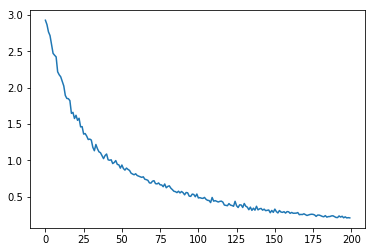

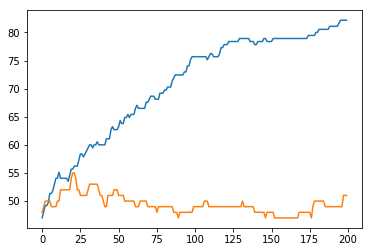

In [58]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [59]:
max(epoch_accuracies[1])

55.0

## Save model and scaler

In [60]:
torch.save(best_model.state_dict(), "models/yoked_force_model.pt")
joblib.dump(scaler, "scalers/yoked_force_scaler.sk")

['scalers/yoked_force_scaler.sk']

## Evaluate saved model



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 559.24it/s]

Model's accuracy on test set: 100.0


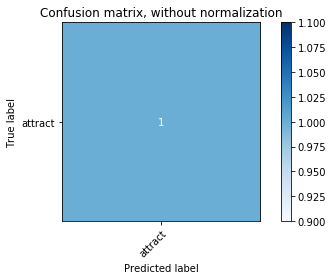

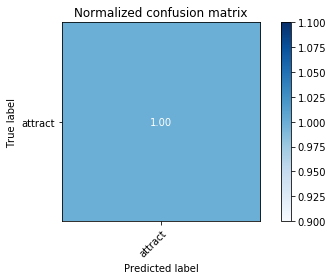

In [61]:
model_path = "models/yoked_force_model.pt"
scaler_path = "scalers/yoked_force_scaler.sk"
network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)
class_columns = FORCE_CLASS_COLS

evaluate_saved_model(model_path, list(network_dims) + [DROPOUT], None, BASIC_TRAINING_COLS,
                     class_columns=class_columns, step_size=STEP_SIZE, scaler_path=scaler_path, trials=test_trials)

# MASS TRAINING (Humans achieve 45% +- 20%)

## Read dataset and preprocess it

In [22]:
scaler = joblib.load("scalers/passive_mass_scaler.sk")

In [23]:
loaders, scaler = prepare_dataset([train_trials, val_trials, test_trials], training_columns=BASIC_TRAINING_COLS, 
                                  class_columns=MASS_CLASS_COLS, batch_size=BATCH_SIZE, 
                                  normalise_data=NORMALISE_DATA, scaler=scaler)

100%|██████████| 100/100 [00:00<00:00, 1159.76it/s]


In [24]:
train_loader, val_loader, test_loader = loaders

In [25]:
class_proportions(train_loader)
class_proportions(val_loader)
class_proportions(test_loader)

[266 226 242]
Majority class:  0.36239782016348776
[84 69 97]
Majority class:  0.388
[34 22 44]
Majority class:  0.44


## Define model, loss and optimizer

## Train model and plot loss and accuracy

In [28]:
model_path = "models/passive_mass_model.pt"
model = ComplexRNNModel(*network_dims, DROPOUT)
model.load_state_dict(torch.load(model_path))
model.train()
model = model.cuda()
model.rec_one.requires_grad = False

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [29]:
epoch_losses, epoch_accuracies, best_model = training_loop(model, optimizer, error, train_loader, val_loader, EPOCHS, 
                                                           step_size=STEP_SIZE)


  0%|          | 0/200 [00:00<?, ?it/s]
Train_loss (1.83)	 Train_acc (52.18)	 Val_acc (50.40):   0%|          | 0/200 [00:02<?, ?it/s]
Train_loss (1.83)	 Train_acc (52.18)	 Val_acc (50.40):   0%|          | 1/200 [00:02<06:40,  2.01s/it]
Train_loss (1.17)	 Train_acc (54.22)	 Val_acc (50.40):   0%|          | 1/200 [00:03<06:40,  2.01s/it]
Train_loss (1.17)	 Train_acc (54.22)	 Val_acc (50.40):   1%|          | 2/200 [00:03<06:37,  2.01s/it]
Train_loss (0.97)	 Train_acc (54.36)	 Val_acc (46.00):   1%|          | 2/200 [00:05<06:37,  2.01s/it]
Train_loss (0.97)	 Train_acc (54.36)	 Val_acc (46.00):   2%|▏         | 3/200 [00:05<06:33,  2.00s/it]
Train_loss (0.95)	 Train_acc (54.77)	 Val_acc (49.20):   2%|▏         | 3/200 [00:07<06:33,  2.00s/it]
Train_loss (0.95)	 Train_acc (54.77)	 Val_acc (49.20):   2%|▏         | 4/200 [00:07<06:30,  1.99s/it]
Train_loss (0.93)	 Train_acc (55.18)	 Val_acc (47.20):   2%|▏         | 4/200 [00:09<06:30,  1.99s/it]
Train_loss (0.93)	 Train_acc (55.18)	 Va

Train_loss (0.24)	 Train_acc (79.02)	 Val_acc (48.40):  19%|█▉        | 38/200 [01:17<05:18,  1.97s/it]
Train_loss (0.24)	 Train_acc (79.02)	 Val_acc (48.40):  20%|█▉        | 39/200 [01:17<05:16,  1.97s/it]
Train_loss (0.22)	 Train_acc (79.16)	 Val_acc (54.00):  20%|█▉        | 39/200 [01:19<05:16,  1.97s/it]
Train_loss (0.22)	 Train_acc (79.16)	 Val_acc (54.00):  20%|██        | 40/200 [01:19<05:14,  1.97s/it]
Train_loss (0.26)	 Train_acc (75.75)	 Val_acc (52.40):  20%|██        | 40/200 [01:21<05:14,  1.97s/it]
Train_loss (0.26)	 Train_acc (75.75)	 Val_acc (52.40):  20%|██        | 41/200 [01:21<05:13,  1.97s/it]
Train_loss (0.25)	 Train_acc (79.84)	 Val_acc (51.20):  20%|██        | 41/200 [01:23<05:13,  1.97s/it]
Train_loss (0.25)	 Train_acc (79.84)	 Val_acc (51.20):  21%|██        | 42/200 [01:23<05:11,  1.97s/it]
Train_loss (0.23)	 Train_acc (79.43)	 Val_acc (52.00):  21%|██        | 42/200 [01:25<05:11,  1.97s/it]
Train_loss (0.23)	 Train_acc (79.43)	 Val_acc (52.00):  22%|██▏ 

Train_loss (0.63)	 Train_acc (67.57)	 Val_acc (46.00):  38%|███▊      | 76/200 [02:34<04:17,  2.08s/it]
Train_loss (0.63)	 Train_acc (67.57)	 Val_acc (46.00):  38%|███▊      | 77/200 [02:34<04:15,  2.08s/it]
Train_loss (0.62)	 Train_acc (67.85)	 Val_acc (43.60):  38%|███▊      | 77/200 [02:36<04:15,  2.08s/it]
Train_loss (0.62)	 Train_acc (67.85)	 Val_acc (43.60):  39%|███▉      | 78/200 [02:36<04:12,  2.07s/it]
Train_loss (0.59)	 Train_acc (68.26)	 Val_acc (43.60):  39%|███▉      | 78/200 [02:38<04:12,  2.07s/it]
Train_loss (0.59)	 Train_acc (68.26)	 Val_acc (43.60):  40%|███▉      | 79/200 [02:38<04:08,  2.05s/it]
Train_loss (0.59)	 Train_acc (70.44)	 Val_acc (44.00):  40%|███▉      | 79/200 [02:40<04:08,  2.05s/it]
Train_loss (0.59)	 Train_acc (70.44)	 Val_acc (44.00):  40%|████      | 80/200 [02:40<04:08,  2.07s/it]
Train_loss (0.54)	 Train_acc (69.62)	 Val_acc (44.40):  40%|████      | 80/200 [02:42<04:08,  2.07s/it]
Train_loss (0.54)	 Train_acc (69.62)	 Val_acc (44.40):  40%|████

Train_loss (0.19)	 Train_acc (79.56)	 Val_acc (44.40):  57%|█████▋    | 114/200 [03:50<02:50,  1.99s/it]
Train_loss (0.19)	 Train_acc (79.56)	 Val_acc (44.40):  57%|█████▊    | 115/200 [03:50<02:48,  1.98s/it]
Train_loss (0.20)	 Train_acc (80.52)	 Val_acc (44.80):  57%|█████▊    | 115/200 [03:52<02:48,  1.98s/it]
Train_loss (0.20)	 Train_acc (80.52)	 Val_acc (44.80):  58%|█████▊    | 116/200 [03:52<02:46,  1.99s/it]
Train_loss (0.18)	 Train_acc (79.16)	 Val_acc (44.40):  58%|█████▊    | 116/200 [03:54<02:46,  1.99s/it]
Train_loss (0.18)	 Train_acc (79.16)	 Val_acc (44.40):  58%|█████▊    | 117/200 [03:54<02:44,  1.98s/it]
Train_loss (0.16)	 Train_acc (77.79)	 Val_acc (45.60):  58%|█████▊    | 117/200 [03:56<02:44,  1.98s/it]
Train_loss (0.16)	 Train_acc (77.79)	 Val_acc (45.60):  59%|█████▉    | 118/200 [03:56<02:42,  1.98s/it]
Train_loss (0.18)	 Train_acc (79.70)	 Val_acc (44.00):  59%|█████▉    | 118/200 [03:58<02:42,  1.98s/it]
Train_loss (0.18)	 Train_acc (79.70)	 Val_acc (44.00): 

Train_loss (0.11)	 Train_acc (79.43)	 Val_acc (47.60):  76%|███████▌  | 152/200 [05:04<01:35,  1.99s/it]
Train_loss (0.10)	 Train_acc (79.29)	 Val_acc (46.40):  76%|███████▌  | 152/200 [05:06<01:35,  1.99s/it]
Train_loss (0.10)	 Train_acc (79.29)	 Val_acc (46.40):  76%|███████▋  | 153/200 [05:06<01:36,  2.06s/it]
Train_loss (0.10)	 Train_acc (80.52)	 Val_acc (49.20):  76%|███████▋  | 153/200 [05:08<01:36,  2.06s/it]
Train_loss (0.10)	 Train_acc (80.52)	 Val_acc (49.20):  77%|███████▋  | 154/200 [05:08<01:34,  2.05s/it]
Train_loss (0.08)	 Train_acc (80.52)	 Val_acc (48.00):  77%|███████▋  | 154/200 [05:10<01:34,  2.05s/it]
Train_loss (0.08)	 Train_acc (80.52)	 Val_acc (48.00):  78%|███████▊  | 155/200 [05:10<01:31,  2.02s/it]
Train_loss (0.11)	 Train_acc (80.52)	 Val_acc (45.60):  78%|███████▊  | 155/200 [05:12<01:31,  2.02s/it]
Train_loss (0.11)	 Train_acc (80.52)	 Val_acc (45.60):  78%|███████▊  | 156/200 [05:12<01:28,  2.01s/it]
Train_loss (0.08)	 Train_acc (80.25)	 Val_acc (46.40): 

Train_loss (0.08)	 Train_acc (81.06)	 Val_acc (44.80):  94%|█████████▍| 189/200 [06:20<00:22,  2.02s/it]
Train_loss (0.08)	 Train_acc (81.06)	 Val_acc (44.80):  95%|█████████▌| 190/200 [06:20<00:20,  2.01s/it]
Train_loss (0.06)	 Train_acc (79.70)	 Val_acc (44.80):  95%|█████████▌| 190/200 [06:22<00:20,  2.01s/it]
Train_loss (0.06)	 Train_acc (79.70)	 Val_acc (44.80):  96%|█████████▌| 191/200 [06:22<00:18,  2.00s/it]
Train_loss (0.06)	 Train_acc (80.79)	 Val_acc (44.80):  96%|█████████▌| 191/200 [06:24<00:18,  2.00s/it]
Train_loss (0.06)	 Train_acc (80.79)	 Val_acc (44.80):  96%|█████████▌| 192/200 [06:24<00:15,  2.00s/it]
Train_loss (0.06)	 Train_acc (81.34)	 Val_acc (45.20):  96%|█████████▌| 192/200 [06:26<00:15,  2.00s/it]
Train_loss (0.06)	 Train_acc (81.34)	 Val_acc (45.20):  96%|█████████▋| 193/200 [06:26<00:13,  1.99s/it]
Train_loss (0.05)	 Train_acc (80.93)	 Val_acc (45.60):  96%|█████████▋| 193/200 [06:28<00:13,  1.99s/it]
Train_loss (0.05)	 Train_acc (80.93)	 Val_acc (45.60): 

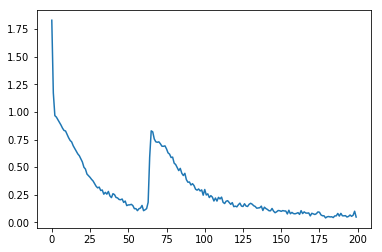

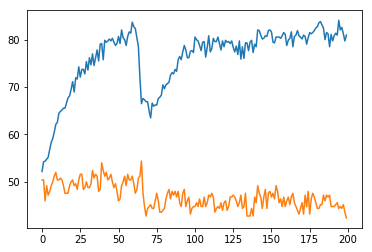

In [30]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [31]:
max(epoch_accuracies[1])

54.4

## Save model and scaler

In [32]:
torch.save(best_model.state_dict(), "models/yoked_mass_model.pt")
joblib.dump(scaler, "scalers/yoked_mass_scaler.sk")

['scalers/yoked_mass_scaler.sk']

## Load model and evaluate


100%|██████████| 100/100 [00:00<00:00, 1185.19it/s]

Model's accuracy on test set: 49.0


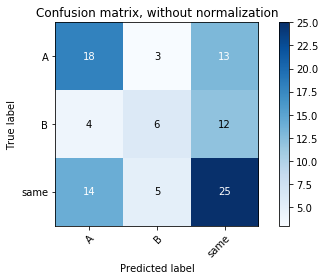

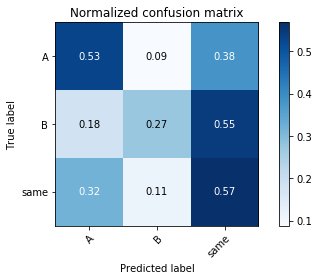

In [33]:
model_path = "models/yoked_mass_model.pt"
scaler_path = "scalers/yoked_mass_scaler.sk"
network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)
class_columns = MASS_CLASS_COLS

evaluate_saved_model(model_path, network_dims, None, BASIC_TRAINING_COLS,
                     class_columns, step_size=STEP_SIZE, scaler_path=scaler_path, trials=test_trials)